In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
from datasets import available_datasets
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [2]:
def read_logs(path, task, **params):
    df_results = pd.DataFrame()
    for config in tqdm(list(product(*params.values()))):
        experiment_file = os.path.join(
            path,
            f'task:{task}',
            *[f'{key}:{value}' for key, value in zip(params.keys(), config)],
            'metrics.csv'
        )
        df = pd.read_csv(experiment_file)
        for key, value in zip(params.keys(), config):
            df[key] = value
        df_results = df_results.append(df, ignore_index=True)
    return df_results


def explode(df, col, val):
    df[col] = [val for _ in range(len(df))]
    df = df.explode(col, ignore_index=True)
    return df


def export_figure(path, df, x, y, hue, row, col, group, error=None):
    if not os.path.exists(path):
        os.makedirs(path)
    
    if error is None:
        df = df.groupby([group, row, col, hue, x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        output = [x, y, error]
        
    df['filename'] = df[[group, row, col, hue]].apply(lambda row: '-'.join(row.astype(str)) + f'-{x}.txt', axis=1)
    df.groupby('filename').apply(
        lambda row: row[output].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )
    

def latex_output(df_results, top_method, colored_method=None, color=None, size=None):
    if size is not None:
        df_results = df_results.applymap(lambda x: f'{{{size} {x}}}')
        
    if color is not None:
        df_results.loc[pd.IndexSlice[:, 'DPGNN'], :] = df_results.loc[pd.IndexSlice[:, 'DPGNN'], :].applymap(
            lambda x: f'\textcolor{{{color}}}{{{x}}}'
        )
        
    # print latex code
    cols = df_results.shape[1] + 2
    latex = df_results.to_latex(escape=False)
    for line in latex.splitlines():
        if line.find(top_method + ' ') == -1:
            print(line)
        else:
            print('\\midrule')
            print(line)

In [19]:
results_path = 'results-new'
datasets = available_datasets()

## Analysis of the utility-privacy trade-off

In [20]:
epsilons = [0.1, 0.5, 1.0, 2.0, 4.0]

data_dpgnn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=[1,2,4,8,16,32],
    agg=['gcn'],
    selfloops=[False],
)

data_gcn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw', 'rnd', 'ohd'], 
    eps=[0.0],
    step=[1],
    agg=['gcn'],
    selfloops=[True],
)

data_gcn = explode(data_gcn, col='eps', val=epsilons)

In [22]:
names = {
    'raw': '1-GCN+Raw',
    'mbm': '2-DPGNN',
    'rnd': '3-GCN+Rnd',
    'ohd': '4-GCN+Ohd',
    'cora': '1-Cora',
    'citeseer': '2-Citeseer',
    'pubmed': '3-Pubmed',
    'facebook': '4-Facebook',
    'github': '5-Github',
    'lastfm': '6-LastFM'
}
df_mean = data_dpgnn.groupby(['dataset', 'eps', 'step'])['test_acc'].mean().reset_index()
idx = df_mean.groupby(['dataset', 'eps'])['test_acc'].transform(max) == df_mean['test_acc']
df_max = df_mean[idx]
df_final = data_dpgnn.merge(df_max.drop(columns='test_acc'), on=['dataset', 'eps', 'step'], how='inner')
data = df_final.append(data_gcn, ignore_index=True)
data = data.groupby(['dataset', 'method', 'eps']).agg({'test_acc': ['mean', lambda x: np.std(x)]}).reset_index()
data = data.replace(names)
data.columns = ['Dataset', 'Method', '$\epsilon$', 'mean', 'std']
data['result'] = data[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean'], row['std']), axis=1)
data = data.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$'])
data = data.unstack()
data = data.rename(index=lambda name: name[2:] if name[1] == '-' else name)
data
# latex_output(data, top_method='GCN+Raw', size='\scriptsize', color='blue', colored_method='DPGNN')

result                                                                
$\epsilon$                   0.1             0.5             1.0             2.0             4.0
Dataset  Method                                                                                 
Cora     GCN+Raw  85.2 $\pm$ 0.5  85.2 $\pm$ 0.5  85.2 $\pm$ 0.5  85.2 $\pm$ 0.5  85.2 $\pm$ 0.5
         DPGNN    84.5 $\pm$ 0.6  84.5 $\pm$ 0.5  84.5 $\pm$ 0.6  84.5 $\pm$ 0.6  84.6 $\pm$ 0.6
         GCN+Rnd  77.6 $\pm$ 1.0  77.6 $\pm$ 1.0  77.6 $\pm$ 1.0  77.6 $\pm$ 1.0  77.6 $\pm$ 1.0
         GCN+Ohd  57.7 $\pm$ 0.7  57.7 $\pm$ 0.7  57.7 $\pm$ 0.7  57.7 $\pm$ 0.7  57.7 $\pm$ 0.7
Citeseer GCN+Raw  73.7 $\pm$ 0.5  73.7 $\pm$ 0.5  73.7 $\pm$ 0.5  73.7 $\pm$ 0.5  73.7 $\pm$ 0.5
         DPGNN    68.5 $\pm$ 0.9  68.4 $\pm$ 0.9  68.0 $\pm$ 1.0  68.1 $\pm$ 0.9  68.3 $\pm$ 1.0
         GCN+Rnd  53.9 $\pm$ 9.8  53.9 $\pm$ 9.8  53.9 $\pm$ 9.8  53.9 $\pm$ 9.8  53.9 $\pm$ 9.8
         GCN+Ohd  38.5 $\pm$ 1.5  38.5 $\pm$ 1.5  38.5 $\pm$ 1.5  38.5 $\pm$ 1.5  38.5 $\pm$ 1.5
Pubmed   GCN+Raw  86.8 $\pm$ 0.3  86.8 $\pm$ 0.3  86.8 $\pm$ 0.3  86.8 $\pm$ 0.3  86.8 $\pm$ 0.3
         DPGNN    82.4 $\pm$ 0.3  82.5 $\pm$ 0.2  82.4 $\pm$ 0.2  82.2 $\pm$ 0.3  82.2 $\pm$ 0.2
         GCN+Rnd  56.3 $\pm$ 1.8  56.3 $\pm$ 1.8  56.3 $\pm$ 1.8  56.3 $\pm$ 1.8  56.3 $\pm$ 1.8
         GCN+Ohd  63.0 $\pm$ 0.9  63.0 $\pm$ 0.9  63.0 $\pm$ 0.9  63.0 $\pm$ 0.9  63.0 $\pm$ 0.9
Facebook GCN+Raw  94.9 $\pm$ 0.1  94.9 $\pm$ 0.1  94.9 $\pm$ 0.1  94.9 $\pm$ 0.1  94.9 $\pm$ 0.1
         DPGNN    93.8 $\pm$ 0.2  93.8 $\pm$ 0.1  93.9 $\pm$ 0.1  93.9 $\pm$ 0.2  93.9 $\pm$ 0.2
         GCN+Rnd  39.6 $\pm$ 2.9  39.6 $\pm$ 2.9  39.6 $\pm$ 2.9  39.6 $\pm$ 2.9  39.6 $\pm$ 2.9
         GCN+Ohd  77.7 $\pm$ 0.2  77.7 $\pm$ 0.2  77.7 $\pm$ 0.2  77.7 $\pm$ 0.2  77.7 $\pm$ 0.2
Github   GCN+Raw  86.6 $\pm$ 0.1  86.6 $\pm$ 0.1  86.6 $\pm$ 0.1  86.6 $\pm$ 0.1  86.6 $\pm$ 0.1
         DPGNN    86.1 $\pm$ 0.1  86.1 $\pm$ 0.1  86.1 $\pm$ 0.1  86.1 $\pm$ 0.2  86.0 $\pm$ 0.0
         GCN+Rnd  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0
         GCN+Ohd  83.7 $\pm$ 0.1  83.7 $\pm$ 0.1  83.7 $\pm$ 0.1  83.7 $\pm$ 0.1  83.7 $\pm$ 0.1
LastFM   GCN+Raw  87.9 $\pm$ 0.3  87.9 $\pm$ 0.3  87.9 $\pm$ 0.3  87.9 $\pm$ 0.3  87.9 $\pm$ 0.3
         DPGNN    86.1 $\pm$ 0.2  86.0 $\pm$ 0.3  86.1 $\pm$ 0.2  86.0 $\pm$ 0.3  86.0 $\pm$ 0.4
         GCN+Rnd  21.7 $\pm$ 0.1  21.7 $\pm$ 0.1  21.7 $\pm$ 0.1  21.7 $\pm$ 0.1  21.7 $\pm$ 0.1
         GCN+Ohd  70.5 $\pm$ 0.6  70.5 $\pm$ 0.6  70.5 $\pm$ 0.6  70.5 $\pm$ 0.6  70.5 $\pm$ 0.6

## Studying the effect of multi-bit mechanism

In [6]:
df_error = read_logs(
    path=results_path, 
    task='error', 
    dataset=datasets, 
    method=['obm', 'agm', 'mbm'], 
    eps=[0.5, 1.0, 2.0, 4.0], 
    agg=['gcn'], 
)

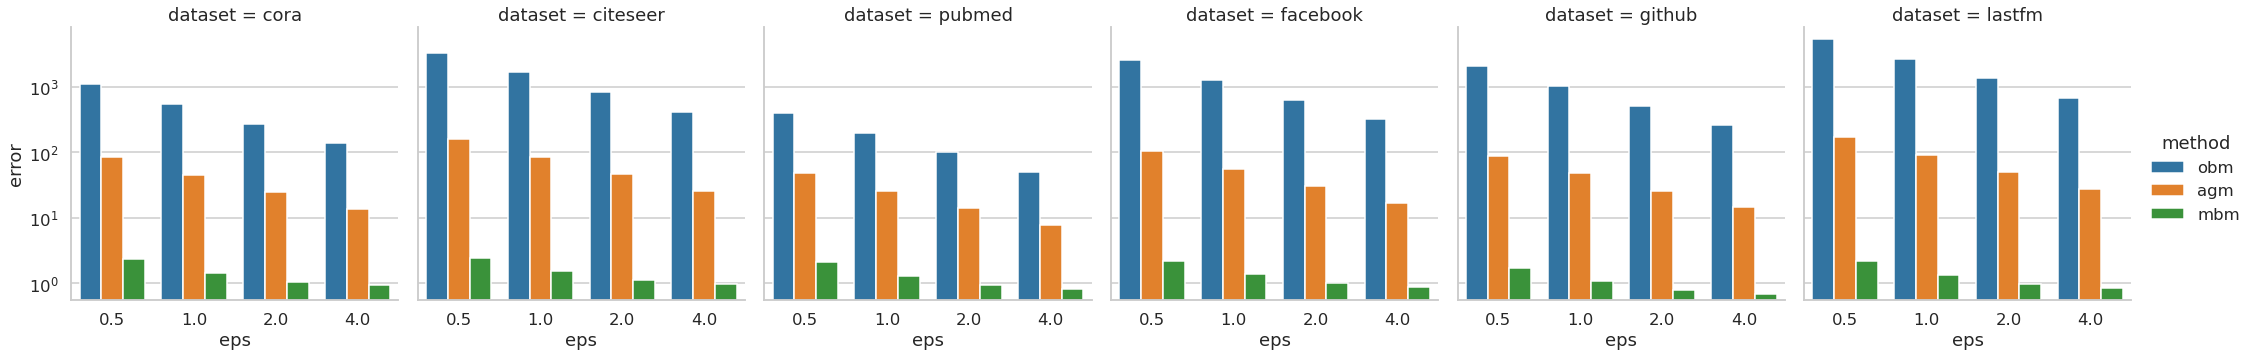

In [7]:
ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='method', col='dataset', ci=None, sharey=True
)
ax.set(yscale='log')

# export_figure(
#     path='figures', df=df_error, x='eps', y='error', hue='method', 
#     col='dataset', row='agg', error='std', group='task'
# )

In [8]:
df_error = read_logs(
    path=results_path, 
    task='error', 
    dataset=datasets, 
    method=['mbm'], 
    eps=[0.5, 1.0, 2.0, 4.0], 
    agg=['mean', 'gcn'], 
)

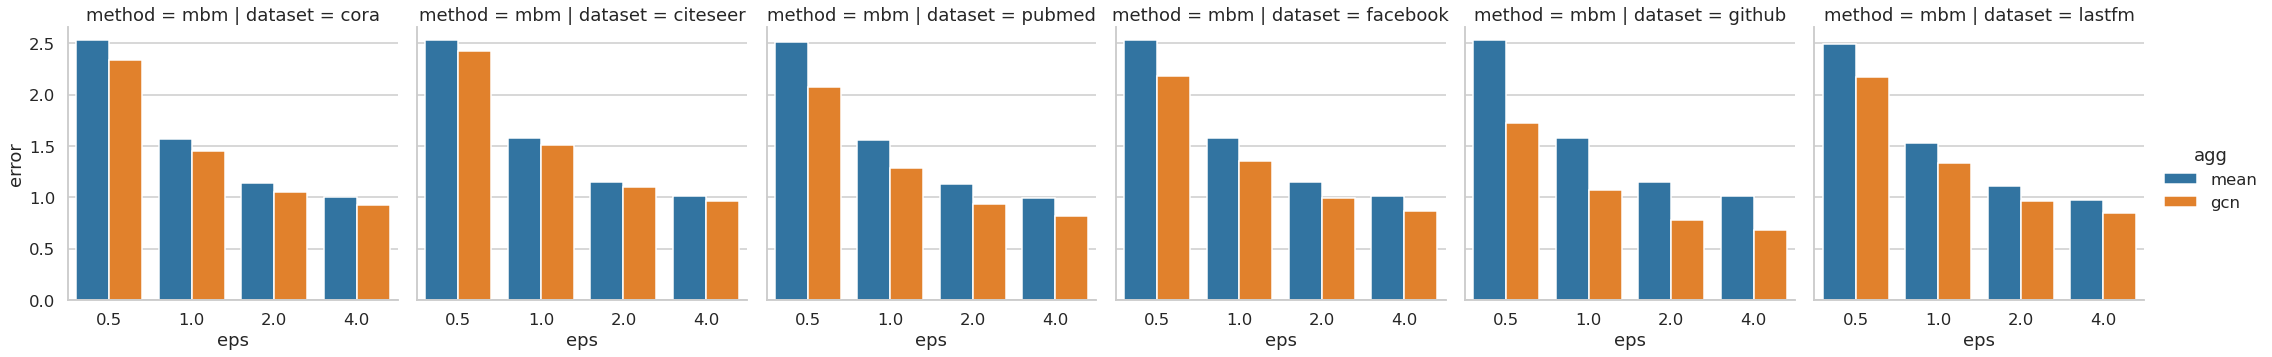

In [9]:
ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='agg', col='dataset', row='method', ci=None, sharey=True
)

# export_figure(
#     path='figures', df=df_error, x='eps', y='error', hue='agg', 
#     col='dataset', row='method', error='std', group='task'
# )

## Studying the effect of KProp

In [10]:
epsilons = [0.1, 1.0, 4.0]
hops = [1, 2, 4, 8, 16, 32]

data_dpgnn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=hops,
    agg=['gcn'],
    selfloops=[False],
)

data_gcn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw'], 
    eps=[0.0],
    step=hops,
    agg=['gcn'],
    selfloops=[False],
)

data = data_dpgnn.append(data_gcn, ignore_index=True)

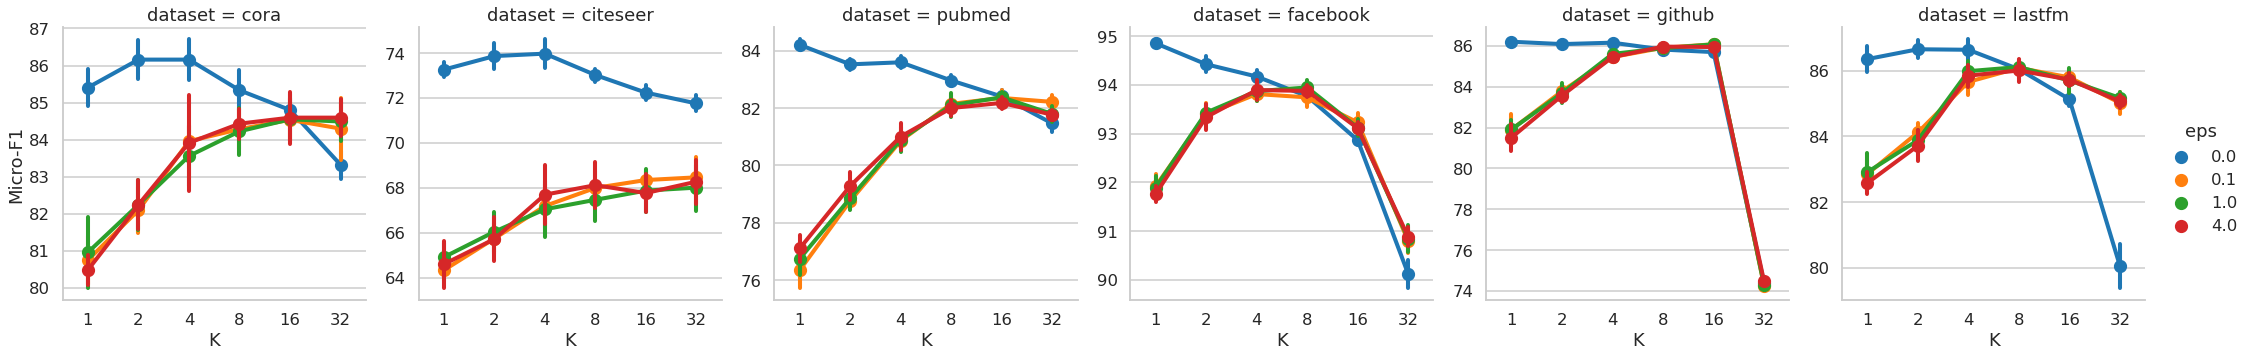

In [11]:
ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

# export_figure(path='figures', df=data, x='step', y='test_acc', hue='eps', row='agg', col='dataset', group='task')

In [12]:
epsilons = [1.0]
hops = [1, 2, 4, 8, 16, 32]

data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets,
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=hops,
    agg=['gcn'],
    selfloops=[False, True],
)

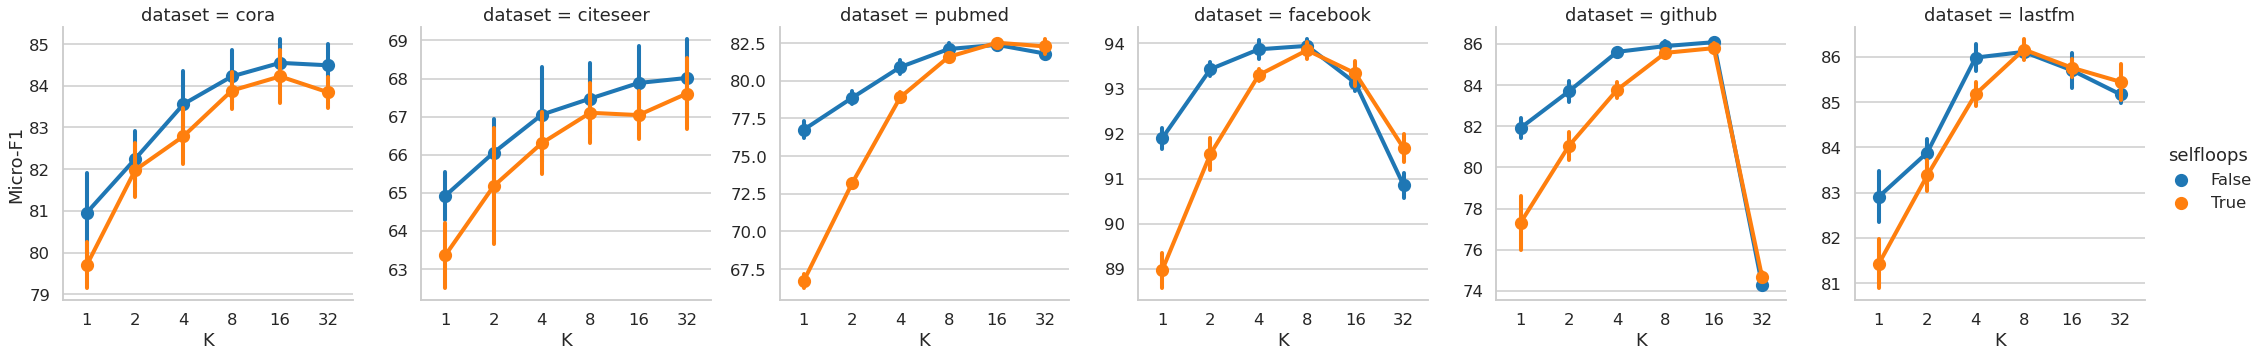

In [13]:
ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='selfloops', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

# export_figure(path='figures', df=data, x='hop', y='value', hue='loop', row='agg', col='dataset', group='task')

## Effect of label rate

In [14]:
data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[0.5, 1.0, 2.0],
    step=[8],
    agg=['gcn'],
    selfloops=[False],
)

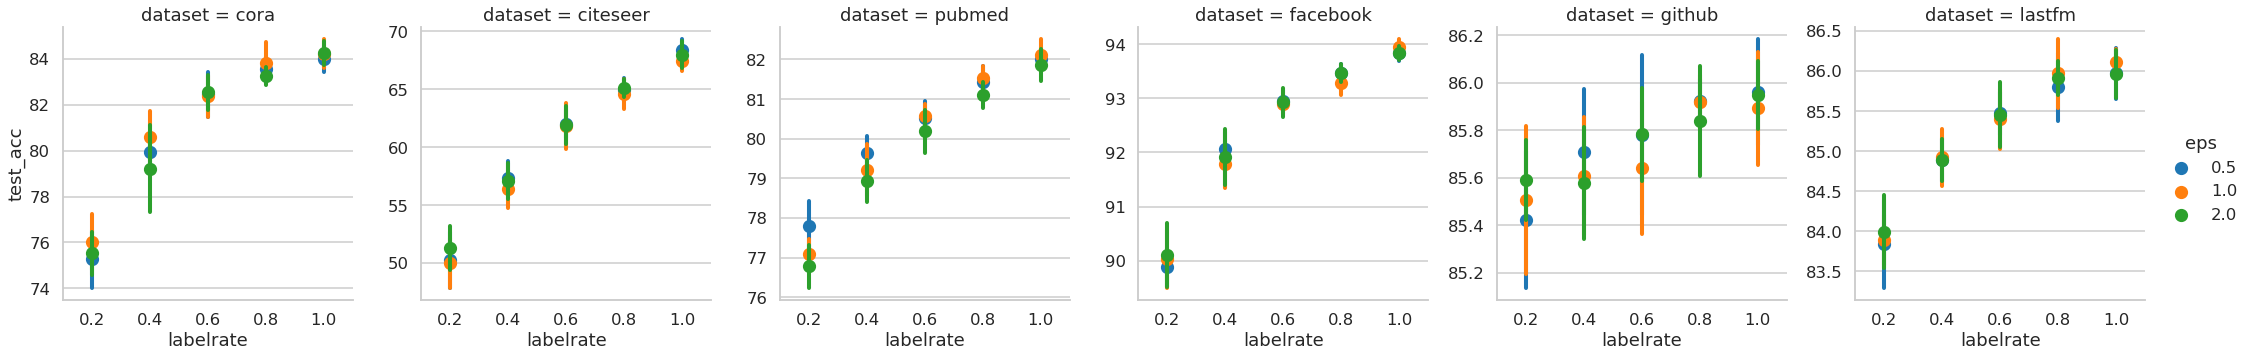

In [15]:
ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

# export_figure(path='figures', df=data, x='labelrate', y='value', hue='eps', row='agg', col='dataset', group='task')

In [16]:
data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[1.0],
    step=[2, 4, 8],
    agg=['gcn'],
    selfloops=[False],
)

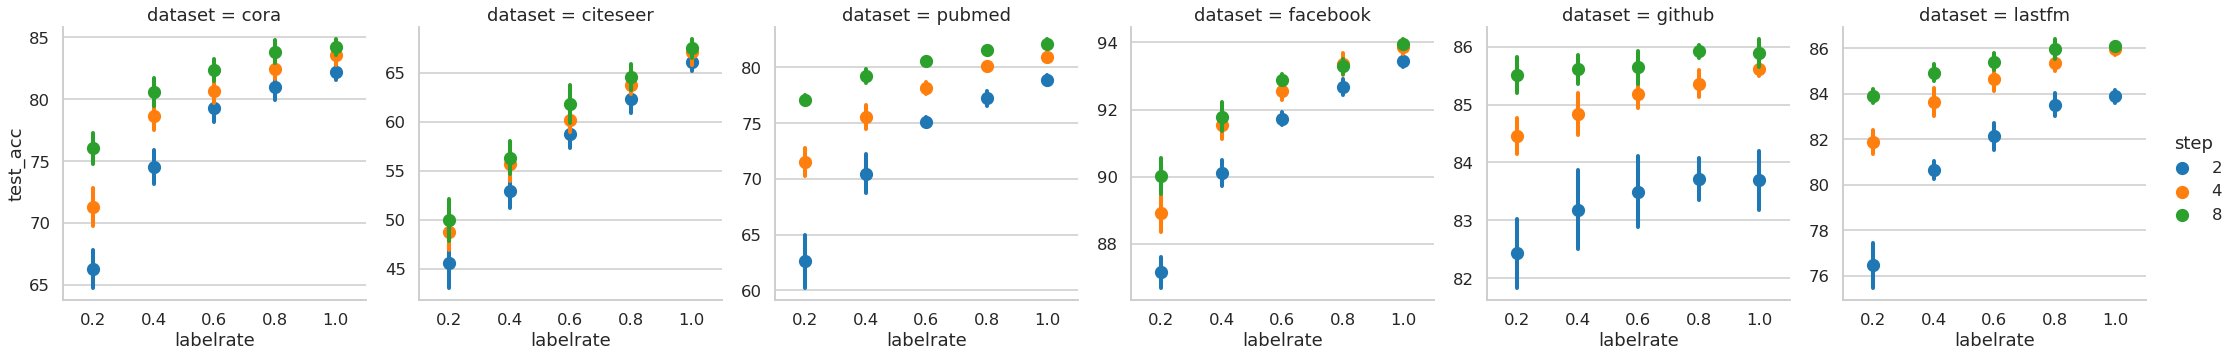

In [17]:
ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='step', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

# ax.set(ylim=40)
# export_figure(path='figures', df=data, x='labelrate', y='value', hue='hop', row='agg', col='dataset', group='task')